# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2024/04/24<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [43]:
import numpy as np
import tensorflow as tf
import keras
from keras import models, layers, losses, optimizers

np.random.seed(1337)

In [44]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 30
BETA = 500

In [45]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  6 23:23:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |   2475MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Create a sampling layer

In [46]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [47]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1), name="Input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 32)           320       ['Input[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_6[0][0]']            
                                                                                                  
 flatten_3 (Flatten)         (None, 3136)                 0         ['conv2d_7[0][0]']            
                                                                                            

## Build the decoder

In [48]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 28, 28, 32)        18464     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 28, 28, 1)         289 

## Define the VAE as a `Model` with a custom `train_step`

In [54]:

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}


In [55]:
vae = VAE(encoder, decoder)

In [56]:
# We are using a custom loss function the KL divergence
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

## Train the VAE

In [57]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 11s 7ms/step - total_loss: 136.6490 - reconstruction_loss: 135.2142 - kl_loss: 1.4348
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - total_loss: 118.1575 - reconstruction_loss: 115.7489 - kl_loss: 2.4087
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - total_loss: 116.0209 - reconstruction_loss: 113.3403 - kl_loss: 2.6806
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - total_loss: 114.4861 - reconstruction_loss: 111.5644 - kl_loss: 2.9216
Epoch 5/30
547/547 [==============================] - 3s 6ms/step - total_loss: 113.3508 - reconstruction_loss: 110.2936 - kl_loss: 3.0572
Epoch 6/30
547/547 [==============================] - 3s 6ms/step - total_loss: 112.6661 - reconstruction_loss: 109.5174 - kl_loss: 3.1488
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - total_loss: 112.1116 - reconstruction_loss: 108.8917 - kl_loss: 3.2199
Epoch 8/30
547/547 [======

## Display a grid of sampled digits

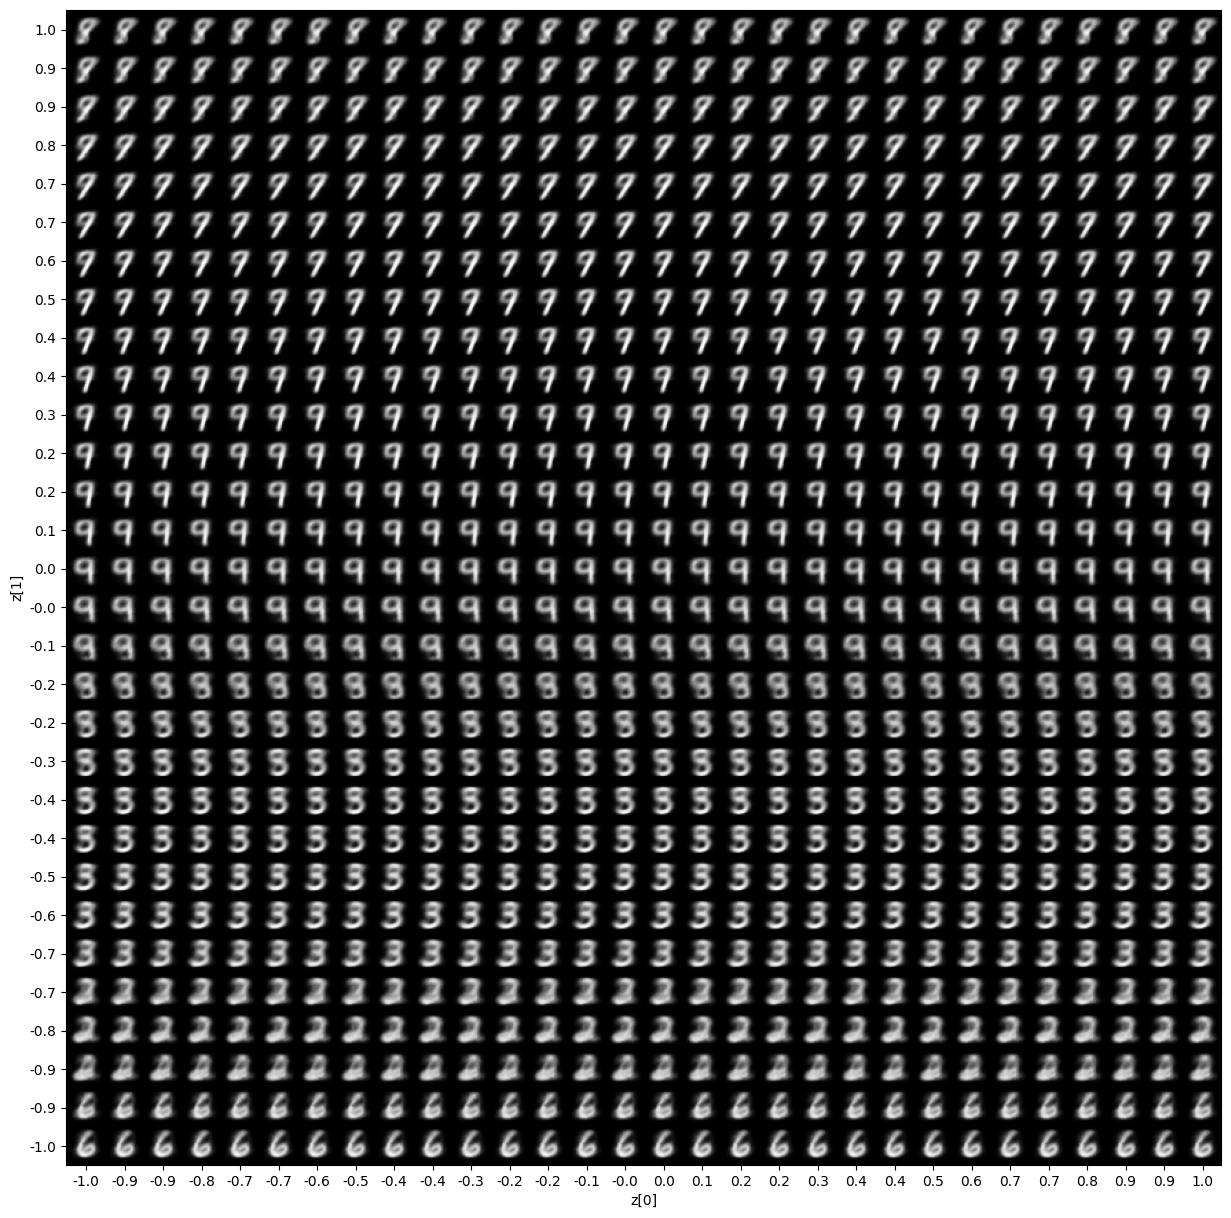

In [58]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

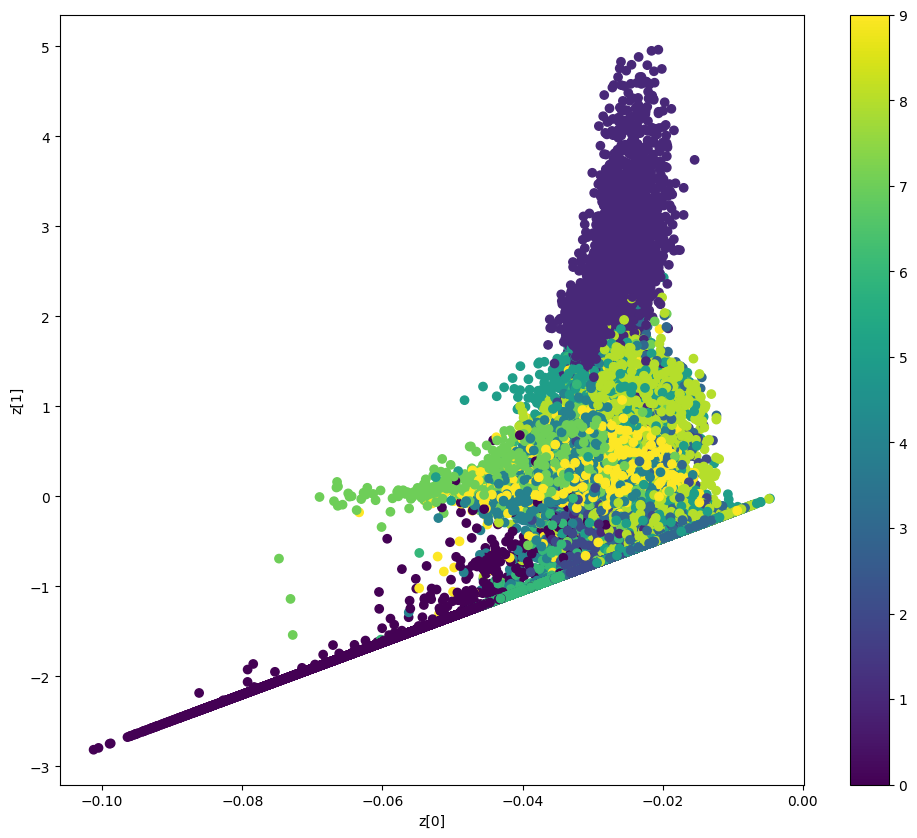

In [59]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)